## Loading input files

In [2]:
def read_heightmap_file(filename):
    input_file = open(filename, "r")
    height_map = []
    for line in input_file:
        #height_map.append(line)
        line = line.split(",")
        row = []
        for number in line:
            row.append(int(number))
        height_map.append(row)
    return height_map

In [3]:
height_map1 = read_heightmap_file("maps/HeightMap.txt")
height_map2 = read_heightmap_file("maps/HeightMap_DeleteMap.txt")
height_map3 = read_heightmap_file("maps/HeightMap_TestMap1.txt")

## Preprocessing height map

In [24]:
# change -1 to np.nan so the height_map is 
# between ymin and ymax
import numpy as np

height_maps = [height_map1, height_map2, height_map3] 

for height_map in height_maps:
    for i in range(len(height_map)):
        for j in range(len(height_map[i])):
            if height_map[i][j] == -1:
                height_map[i][j] = np.nan

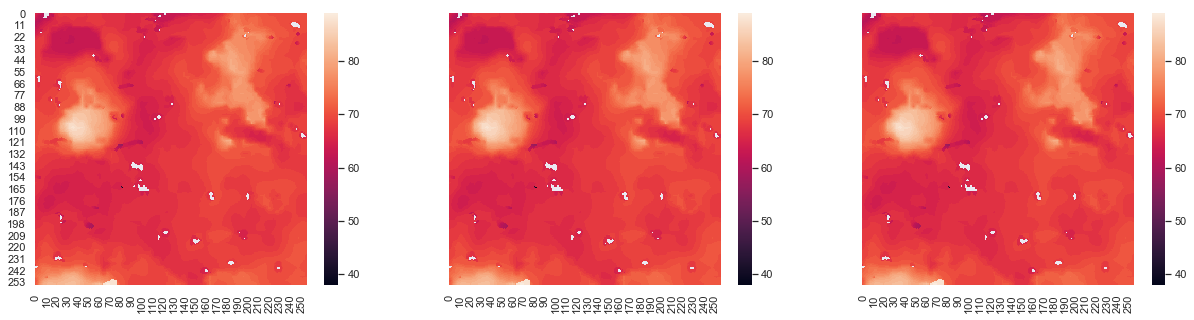

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
cols = 3
fig, axes = plt.subplots(ncols=cols, figsize=(cols*7,5), sharex=True, sharey=True)
for ax in axes:
    sns.heatmap(height_map3, ax=ax)
    ax.set(adjustable='box', aspect='equal')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
plt.figure(figsize=(12.8, 9.6))
ax = sns.heatmap(height_map3)

## Candidate Class

In [311]:
class Candidate:
    def __init__(self, heightmap):
        self.lots = {"big":[],"small":[]}
        self.heightmap = heightmap
        self.fitness = -1
        self.constraints = -1
        
    def __repr__(self):
        repr_ = ""
        #for label, value in self.get_dimensions():
        #    repr_ += "{}: {} ".format(label, value)
        repr_ += "fitness: {} constriants: {}".format(self.fitness, self.constraints)
        return repr_
    
    def get_lots(self):
        return [item for sublist in self.lots.values() for item in sublist]
    
    def get_dimensions(self):
        return [("small",len(self.lots["small"])), ("big",len(self.lots["big"]))]
    
class Lot:
    def __init__(self, x_min, x_max, z_min, z_max, size):
#         self.x_min = x_min
#         self.x_max = x_max
#         self.z_min = z_min
#         self.z_max = z_max
        self.bounds = [x_min, x_max, z_min, z_max]
        self.size = size

**Createing a Candidate**

In [ ]:
cand = new_candidate(height_map3)

In [258]:
def new_candidate(heightmap, initial_lots=10):
    candidate = Candidate(heightmap)
    x_min, z_min = 0, 0
    x_max = len(heightmap)
    z_max = len(heightmap[0])
    for i in range(initial_lots):
        lot = new_lot(x_min,x_max,z_min,z_max)
        candidate.lots[lot.size].append(lot)
    return candidate

## Lot management

In [105]:
import random
def new_lot(x_min, x_max, z_min, z_max):
    lot_types = {"small": new_small_lot, "big": new_big_lot}
    label, function = random.choice(list(lot_types.items()))
    return function(x_min, x_max, z_min, z_max)

small_length = 7
def new_small_lot(x_min, x_max, z_min, z_max):
    if x_max-x_min < small_length: raise Exception('No space for lot')
    x_min = random.randint(x_min, x_max-small_length)
    z_min = random.randint(z_min, z_max-small_length)
    return Lot(x_min, x_min+small_length, z_min, z_min+small_length, "small")
    
big_length = 15
def new_big_lot(x_min, x_max, z_min, z_max):
    if x_max-x_min < big_length: raise Exception('No space for lot')
    x_min = random.randint(x_min, x_max-big_length)
    z_min = random.randint(z_min, z_max-big_length)
    return Lot(x_min, x_min+big_length, z_min, z_min+big_length, "big")

new_lot(0, 255,0,255)

## Constraint Handling

**Collision (two lots overlapping)**

In [131]:
def collision(x1_min, x1_max, z1_min, z1_max,
             x2_min, x2_max, z2_min, z2_max):
    return not (x1_max < x2_min or x1_min > x2_max or z1_max < z2_min or z1_min > z2_max)

def has_collision(candidate):
    lots = candidate.get_lots()
    for i in range(len(lots)-1):
        for j in range(i+1,len(lots)):
            #print("comparing {} with {}".format(i, j))
            if collision(*lots[i].bounds, *lots[j].bounds):
                return 1
    return 0

**Invalid terrain (lot on top of water)**

In [259]:
def water(x_min, x_max, z_min, z_max, heightmap):
    for x in range(x_min, x_max):
        for z in range(z_min, z_max):
            if heightmap[x][z] == -1 or heightmap[x][z] == np.nan:
                return True
    return False

def has_water(candidate):
    lots = candidate.get_lots()
    for lot in lots:
        if water(*lot.bounds, candidate.heightmap):
            return 1
    return 0

**Constraint check aggregator**

In [260]:
def constraint_check(candidate):
    constraints = 0
    
    # check overlapping
    constraints += has_collision(candidate)
    
    # check not on top of water
    constraints += has_water(candidate)

    return constraints

## Genetic Algorithm

**Fitness function**

In [129]:
def count_heights(x_min, x_max, z_min, z_max, heightmap):
    heights = {}
    for x in range(x_min, x_max):
        for z in range(z_min, z_max):
            h = heightmap[x][z]
            if h not in heights.keys():
                heights[h] = 0
    return len(heights.keys())

def countheights_score(candidate): 
    heights = []
    for lot in candidate.get_lots():
        heights.append(count_heights(*(lot.bounds), candidate.heightmap))
    return sum(heights)/len(heights)
# if we make this into a constraint:
#     if sum(heights)/len(heights) < 5:
#         return 0
#     return 1

def fitness(candidate):
    return countheights_score(candidate)

fitness(cand)

4.4

**Mutation Operator**

In [261]:
def mutate(candidate):
    #if coin_flip():
        if coin_flip():
            mutate_newlot(candidate)
        else:
            mutate_removelot(candidate)
                
    # Is it not changing the position of lot
    # equivalent to remove and add a new lot?
    # maybe this mutation operator is not necessary
    #else:
    #    lot = random.choice(candidate.get_lots())
    #    # change position of lot

def mutate_newlot(candidate):
    lot = new_lot(0, len(candidate.heightmap),0,len(candidate.heightmap[0]))
    candidate.lots[lot.size].append(lot)

def mutate_removelot(candidate):
    lot = random.choice(candidate.get_lots()) 
    for key in candidate.lots.keys():
        try: candidate.lots[key].remove(lot)
        except: pass
        

**Crossover Operator**

In [312]:
def crossover(candidate1, candidate2):
    heightmap = candidate1.heightmap
    x = random.randint(0, len(heightmap)-big_length)
    z = random.randint(0, len(heightmap[0])-big_length)
    coin = coin_flip()
    
    child = Candidate(heightmap)
    
    for lot in candidate1.get_lots():
        x_min, x_max, z_min, z_max = lot.bounds
        label = "big" if lot in candidate1.lots["big"] else "small"
        if coin:
            if x_min < x:
                child.lots[label].append(lot)
        else:
            if z_min < z:
                child.lots[label].append(lot)
            
    for lot in candidate2.get_lots():
        x_min, x_max, z_min, z_max = lot.bounds
        label = "big" if lot in candidate1.lots["big"] else "small"
        if coin:
            if x_min > x:
                child.lots[label].append(lot)
        else:
            if z_min > z:
                child.lots[label].append(lot)
                
    child.fitness = fitness(child)
    child.constraints = constraint_check(child)
    return child
    
    print(x,z)
child = crossover(cand, cand)

## Map Elites

In [268]:
from collections import defaultdict

class MapElites:
    def __init__(self):
        # use defaultdict to avoid checking whether a cell was created or not
        self.grid = defaultdict(lambda: defaultdict(list)) 

    def add(self, individual):
        dimensions = individual.get_dimensions()
        #print(dimensions)
        cell = self.grid
        for l, v in dimensions:
            cell = cell[v]
        cell.append(individual)
    
    def get_all(self):
        pass
    
    def get_random(self):
        # travel to the last nesting and pick a random cand
        indiv = self.grid
        while type(indiv) != list:
            indiv = random.choice(list(indiv.values()))
        return random.choice(indiv)

**Initialize population**

In [308]:
def init_pop(pop_size=10):
    candidates = []
    for i in range(pop_size):
        cand = new_candidate(height_map3)
        cand_fitness = fitness(cand)
        cand.fitness = cand_fitness
        cand_constraints = constraint_check(cand)
        cand.constraints = cand_constraints
        #print("Generated candidate fitness: {}, Constraints violated: {}".formated(cand_fitness, cand_constraints))
        candidates.append(cand)
    return candidates
        

## Generation

In [313]:
mapelites = MapElites()

pop = init_pop()
for indiv in pop:
    mapelites.add(indiv)

#import pprint
pprint.pprint(mapelites.grid, width=40)

defaultdict(<function MapElites.__init__.<locals>.<lambda> at 0x133937ef0>,
            {2: defaultdict(<class 'list'>,
                            {8: [fitness: 6.0 constriants: 1,
                                 fitness: 5.1 constriants: 0]}),
             3: defaultdict(<class 'list'>,
                            {7: [fitness: 3.4 constriants: 0,
                                 fitness: 3.2 constriants: 1]}),
             4: defaultdict(<class 'list'>,
                            {6: [fitness: 5.3 constriants: 1]}),
             5: defaultdict(<class 'list'>,
                            {5: [fitness: 4.5 constriants: 0,
                                 fitness: 3.6 constriants: 0]}),
             6: defaultdict(<class 'list'>,
                            {4: [fitness: 3.5 constriants: 1,
                                 fitness: 3.9 constriants: 0]}),
             8: defaultdict(<class 'list'>,
                            {2: [fitness: 3.6 constriants: 0]})})


In [314]:
def generation(mapelites, mutation_rate = 0.1):
    
    p1,p2 = get_parent(mapelites)
        
    child = crossover(p1,p2)
    
    if random.random() < mutation_rate:
        mutate(child)
    
    return p1,p2,child

def get_parent(mapelites):
    p1 = mapelites.get_random()
    p2 = mapelites.get_random()
    return p1, p2

#get_parent(grid)
p1,p2,child = generation(mapelites)
print(p1, p2, child)

fitness: 5.3 constriants: 1 fitness: 3.6 constriants: 0 fitness: 5.285714285714286 constriants: 1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
cols = 3
fig, axes = plt.subplots(ncols=cols, figsize=(cols*7,5), sharex=True, sharey=True)
for ax in axes:
    sns.heatmap(height_map3, ax=ax)
    ax.set(adjustable='box', aspect='equal')
plt.show()

## Misc

In [51]:
def coin_flip():
    return random.random() < 0.5

In [63]:
# auxiliary function to help visualization
def apply_lot_to_heightmap(x_min, x_max, z_min, z_max, heightmap, h):
    for x in range(x_min, x_max+1):
        for z in range(z_min, z_max+1):
            heightmap[x][z] = h
    

In [152]:
for x in range(len(cand.get_lots())):
    lot = cand.get_lots()[x]
    #if(is_valid(*lot, height_map2) == 1):
    #    apply_lot_to_heightmap(*lot, height_map2, 52+x)
    #print(is_valid(*lot, height_map3))
    apply_lot_to_heightmap(*lot, height_map3, 45+x)
    

In [66]:
constraint_check(cand)

1

In [44]:
[item for sublist in cand.lots.values() for item in sublist]

[(138, 145, 159, 166), (19, 26, 117, 124), (238, 245, 118, 125)]

In [239]:
a = grid.grid
print(a.values())
a = random.choice(list(a.values()))
print(a.values())
a = random.choice(list(a.values()))
print(type(a))

dict_values([defaultdict(<class 'list'>, {6: [small: 4 big: 6 ]}), defaultdict(<class 'list'>, {3: [small: 7 big: 3 , small: 7 big: 3 ]}), defaultdict(<class 'list'>, {4: [small: 6 big: 4 , small: 6 big: 4 , small: 6 big: 4 ]}), defaultdict(<class 'list'>, {8: [small: 2 big: 8 ]}), defaultdict(<class 'list'>, {5: [small: 5 big: 5 , small: 5 big: 5 ]}), defaultdict(<class 'list'>, {7: [small: 3 big: 7 ]})])
dict_values([[small: 6 big: 4 , small: 6 big: 4 , small: 6 big: 4 ]])
<class 'list'>


In [287]:
grid.get_random()

small: 8 big: 2 

### TO DO

- Function to get all individuals from the grid